# ECG Classification Machine Learning with SVMs

Apple has hit the headlines in Q4 2018 by launching a new Apple Watch with built in ECG functionality.  This is a big step in wearable eHealth devices as it uses a machine learning algorithm to classify data gathered from the watch’s sensors. This algorithm can be used to detect Atrial fibrillation (A-fib), which is an irregular heartbeat that is linked with an increased risk of heart failure, dementia, and stroke. AFib is often symptomless and contributes to approximately 130,000 deaths annually in the United States . 

An Electrocardiography (ECG) is a record of the electrical activity of the heart usually gathered using electrodes placed on the skin. To capture ECG signals the user must create a closed circuit across their chest as shown in the schema below. Apple get users to do this by simply placing their finger on the front of the watch, so that an electrode touching the wearers wrist on the back of the watch can read the signal. Where the real innovation comes in is the use of machine learning to classify these signals.

<img src="./images/electrodes.png" alt="Placement of ECG electrodes"  height="600" width="600">
<center>Figure 1: Placement of ECG electrodes (By Mikael Häggström - Own work, CC0, https://commons.wikimedia.org/w/index.php?curid=20064293).</center>

Apple developed this machine learning AI using deep learning technology known as convolutional neural networks (CNNs), which are inspired by models of how the brain works. CNNs are the basis of many AI applications especially in the field of computer vision. Such  neural network technology is now widely available to developers on AI platforms from Microsoft Google, Facebook and many more. Here we will explore ECG data from "ECG Heartbeat Categorization Dataset" hosted on Kaggle, with analysis and visualisation, followed by the development of SVM and CNN algorithms for ECG, which we will evaluate.

The data we will use is from the MIT-BIH Arrhythmia Dataset, which contains enough samples for practicing on with SVMs and neural nets. This data has been used in the paper by Kachuee, Mohammad, Shayan Fazeli, and Majid Sarrafzadeh, "ECG Heartbeat Classification: A Deep Transferable Representation." arXiv preprint arXiv:1805.00794 (2018).The signals used in this data set contain a mix of normal heartbeats and heartbeats affected by different forms of arrhythmia. Signals are normaly collected and charted in an electro gardiogram, see figure below, but in this data set the signals are seperated into individual heartbeats.

<img src="https://upload.wikimedia.org/wikipedia/commons/b/bd/12leadECG.jpg" alt="Placement of ECG electrodes">
<center>Figure 2: Placement of ECG electrodes (By MoodyGroove - 2007-01-24 (original upload date)Original uploader was MoodyGroove at en.wikipedia, Public Domain, https://commons.wikimedia.org/w/index.php?curid=5266589).</center>

Firstly we must import the relevant packages and the data, which you can download or find here: https://www.kaggle.com/shayanfazeli/heartbeat

In [42]:
#import packages used in this notebook
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import animation
import seaborn as sns
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix
import itertools 
from matplotlib.colors import Normalize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from matplotlib.collections import LineCollection
from sklearn.metrics import classification_report
import warnings

In [3]:
# Check data folder
print(os.getcwd())
%ls ./data/*.csv

/home/ubuntu/Desktop/ECG
./data/mitbih_test.csv   ./data/ptbdb_abnormal.csv
./data/mitbih_train.csv  ./data/ptbdb_normal.csv


In [4]:
# Load data
train_df = pd.read_csv("./data/mitbih_train.csv", header=None)
test_df = pd.read_csv("./data/mitbih_test.csv", header=None)

In [6]:
# Overview of training data
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Overview of test data
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Coding of Heartbeat Types
The type of heart beat for each sample is stored in the last column of each row, i.e. train_df[187], where the beat type is represented by the following intergers.

* Normal (N) =  0
* Supraventricular (S) = 1
* Ventricular (V) = 2
* Fusion (F) = 3
* Unclassiﬁed (Q) = 4

A normal heartbeat ECG appears as follows:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/SinusRhythmLabels.svg/1024px-SinusRhythmLabels.svg.png" height="600" width="600">
<center>Figure 3: Schematic diagram of normal sinus rhythm for a human heart as seen on ECG (Created by Agateller (Anthony Atkielski), converted to svg by atom).</center>

Abnormal heartbest include Supraventricular tachycardia, wihch  is an abnormally fast heart rhythm arising from improper electrical activity in the upper part of the heart (https://en.wikipedia.org/wiki/Supraventricular_tachycardia), see the effet of this in Figure 4.

<img src="https://upload.wikimedia.org/wikipedia/commons/4/44/Heart_conduct_atrialfib.gif" height="600" width="600">
<center>Figure 4: Atrial fibrillation: Irregular impulses reaching AV node, only some being transmitted. (By JHeuser (based on copyright claims).</center>

These heartbeat classification codes will be the basis of the supervised machine learning to follow. Next we will explore, check and chart the data.

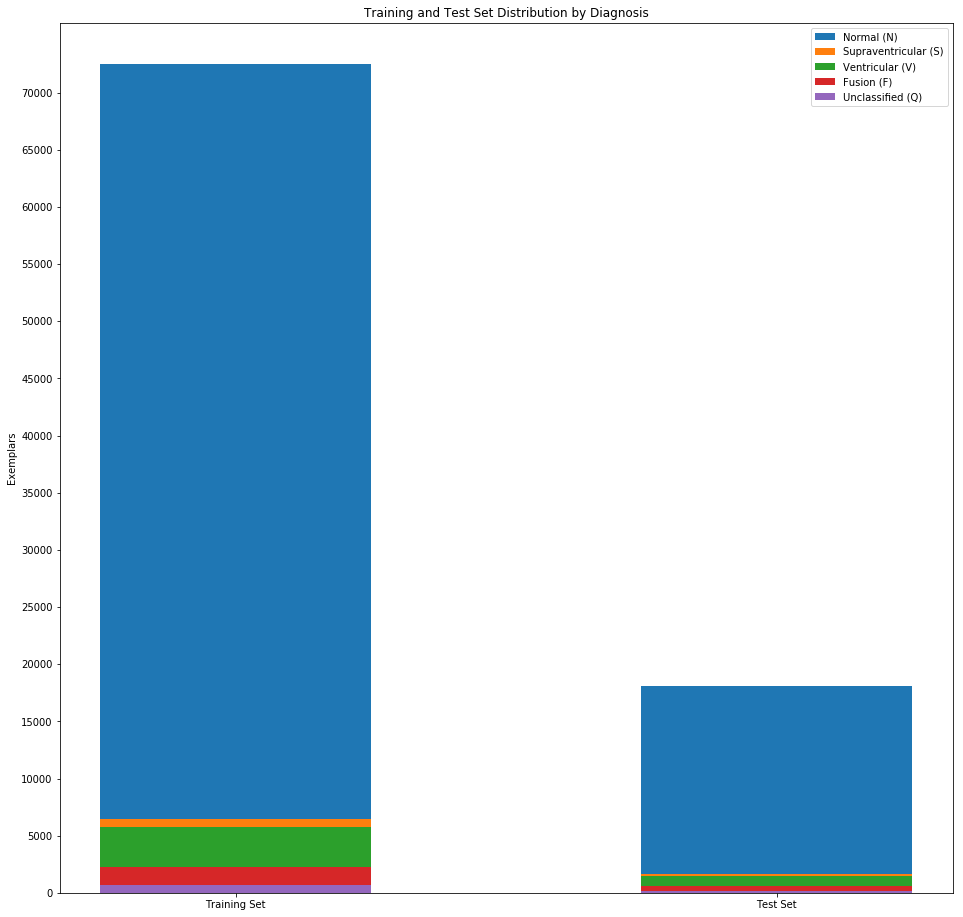

In [8]:
# The type of heart beat for each sample is stored in the last column of each row train_df[187]
# Here we count then number of each.
training_category_counts = train_df[187].value_counts()
test_category_counts = test_df[187].value_counts()
# We will need to reorganise the data for stacked bar plots
bar_plot_data = np.column_stack((training_category_counts, test_category_counts))
bar_width = 0.5
plt.figure(figsize=(16, 16))
x_axis_ticks = np.arange(0, 2 )
p1 = plt.bar(x_axis_ticks, bar_plot_data[0], bar_width )
p2 = plt.bar(x_axis_ticks, bar_plot_data[1], bar_width )
p3 = plt.bar(x_axis_ticks, bar_plot_data[2], bar_width )
p4 = plt.bar(x_axis_ticks, bar_plot_data[3], bar_width )
p5 = plt.bar(x_axis_ticks, bar_plot_data[4], bar_width )
plt.ylabel('Exemplars')
plt.title('Training and Test Set Distribution by Diagnosis')
plt.xticks(x_axis_ticks, ('Training Set', 'Test Set') )
plt.yticks(np.arange(0, 75000, 5000))
plt.legend((p1[0], p2[0],p3[0], p4[0], p5[0]), ('Normal (N)', 'Supraventricular (S)','Ventricular (V)','Fusion (F)','Unclassiﬁed (Q)'))
plt.show();

In [56]:
#Only take a random number of samples for training and test data sets.
sampleFraction = 0.6
X_train = train_df.sample(random_state=1,frac=sampleFraction, replace=True).values[:, :-1]
y_train = train_df.sample(random_state=1,frac=sampleFraction, replace=True).values[:, -1].astype(int)
X_test = test_df.sample(random_state=1,frac=sampleFraction, replace=True).values[:, :-1]
y_test = test_df.sample(random_state=1,frac=sampleFraction, replace=True).values[:, -1].astype(int)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)
# ToDo balance the data sets away from normal bias

X_train (52532, 187)
y_train (52532,)
X_test (13135, 187)
y_test (13135,)


In [55]:
#Only take a random number of samples for training and test data sets.
X_train = train_df.sample(random_state=1,frac=0.6, replace=True).values[:, :-1]
y_train = train_df.sample(random_state=1,frac=0.6, replace=True).values[:, -1].astype(int)
X_test = test_df.sample(random_state=1,frac=0.6, replace=True).values[:, :-1]
y_test = test_df.sample(random_state=1,frac=0.6, replace=True).values[:, -1].astype(int)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)
# ToDo balance the data sets away from normal bias

X_train (52532, 187)
y_train (52532,)
X_test (13135, 187)
y_test (13135,)


In [52]:
# Explore heartbeats
# Show the first row of normal beats, i.e. where value in column 187 == 0
heart = train_df.values[:,187] == 0
train_df[heart].values[:,:-1][0]

array([0.98, 0.93, 0.68, 0.25, 0.15, 0.19, 0.15, 0.09, 0.06, 0.05, 0.04,
       0.06, 0.07, 0.06, 0.05, 0.07, 0.06, 0.06, 0.07, 0.07, 0.1 , 0.08,
       0.09, 0.11, 0.12, 0.1 , 0.12, 0.12, 0.14, 0.13, 0.15, 0.14, 0.16,
       0.14, 0.16, 0.15, 0.15, 0.14, 0.15, 0.15, 0.15, 0.13, 0.13, 0.13,
       0.14, 0.11, 0.11, 0.11, 0.11, 0.1 , 0.09, 0.1 , 0.1 , 0.11, 0.1 ,
       0.12, 0.11, 0.12, 0.13, 0.14, 0.15, 0.14, 0.17, 0.23, 0.24, 0.25,
       0.23, 0.23, 0.2 , 0.18, 0.13, 0.12, 0.12, 0.12, 0.11, 0.13, 0.12,
       0.08, 0.  , 0.07, 0.31, 0.61, 0.86, 1.  , 0.96, 0.75, 0.3 , 0.16,
       0.21, 0.16, 0.1 , 0.1 , 0.09, 0.1 , 0.1 , 0.1 , 0.09, 0.1 , 0.1 ,
       0.11, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

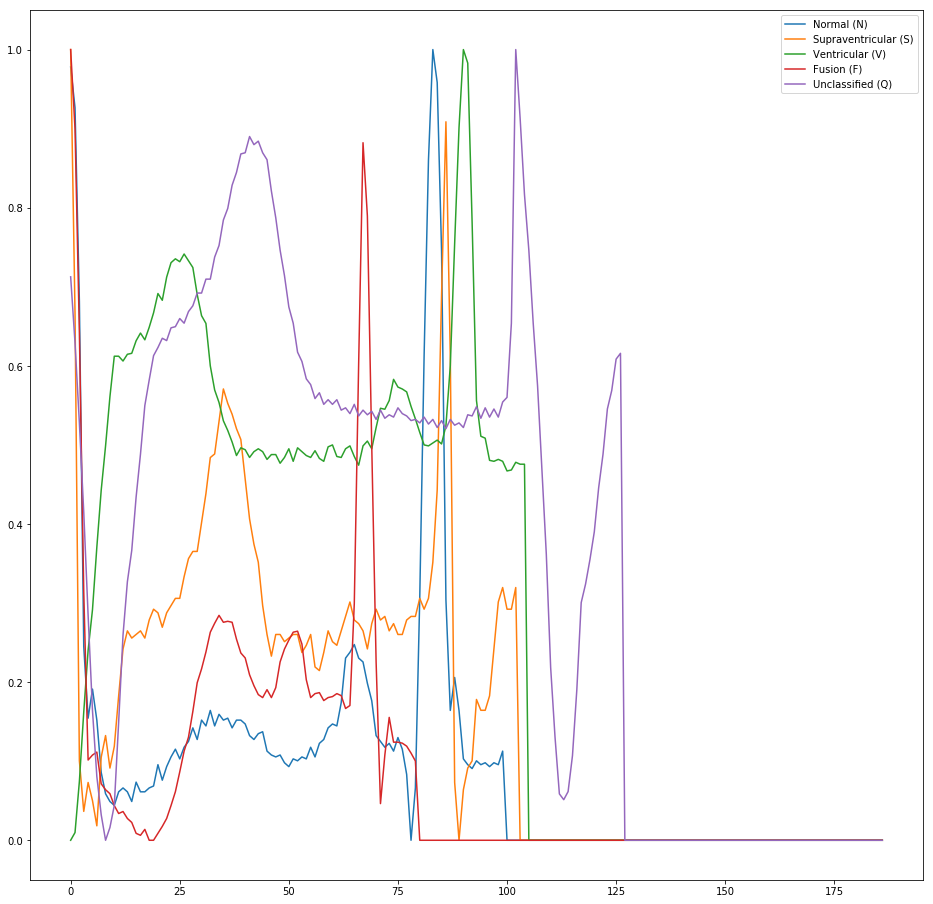

In [46]:
# Plot a sample of heartbeats
x = np.arange(0, 187)
plt.figure(figsize=(16, 16))
normal = train_df.values[:,187] == 0
supraventricular = train_df.values[:,187] == 1
ventricular = train_df.values[:,187] == 2
fusion = train_df.values[:,187] == 3
unclassiﬁed = train_df.values[:,187] == 4
plt.plot(x,train_df[normal].values[:,:-1][0], label="Normal (N)") 
plt.plot(x,train_df[supraventricular].values[:,:-1][0], label="Supraventricular (S)")   
plt.plot(x,train_df[ventricular].values[:,:-1][0], label="Ventricular (V)")   
plt.plot(x,train_df[fusion].values[:,:-1][0], label="Fusion (F)")   
plt.plot(x,train_df[unclassiﬁed].values[:,:-1][0], label="Unclassiﬁed (Q)")   
plt.legend()

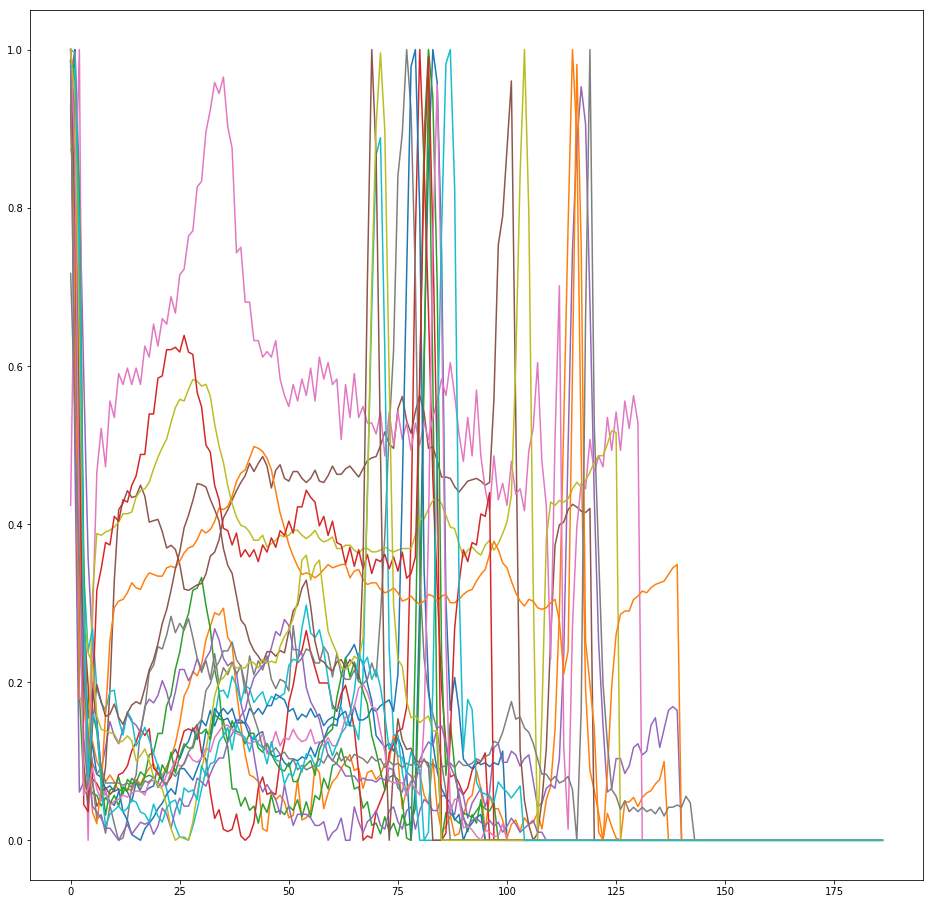

In [47]:
# Plot first 20 normal heartbests to see if we can discern a pattern
x = np.arange(0, 187)
plt.figure(figsize=(16, 16))
for a in range(0, 20):
    plt.plot(x,train_df[normal].values[:,:-1][a], label="Normal "+str(a))

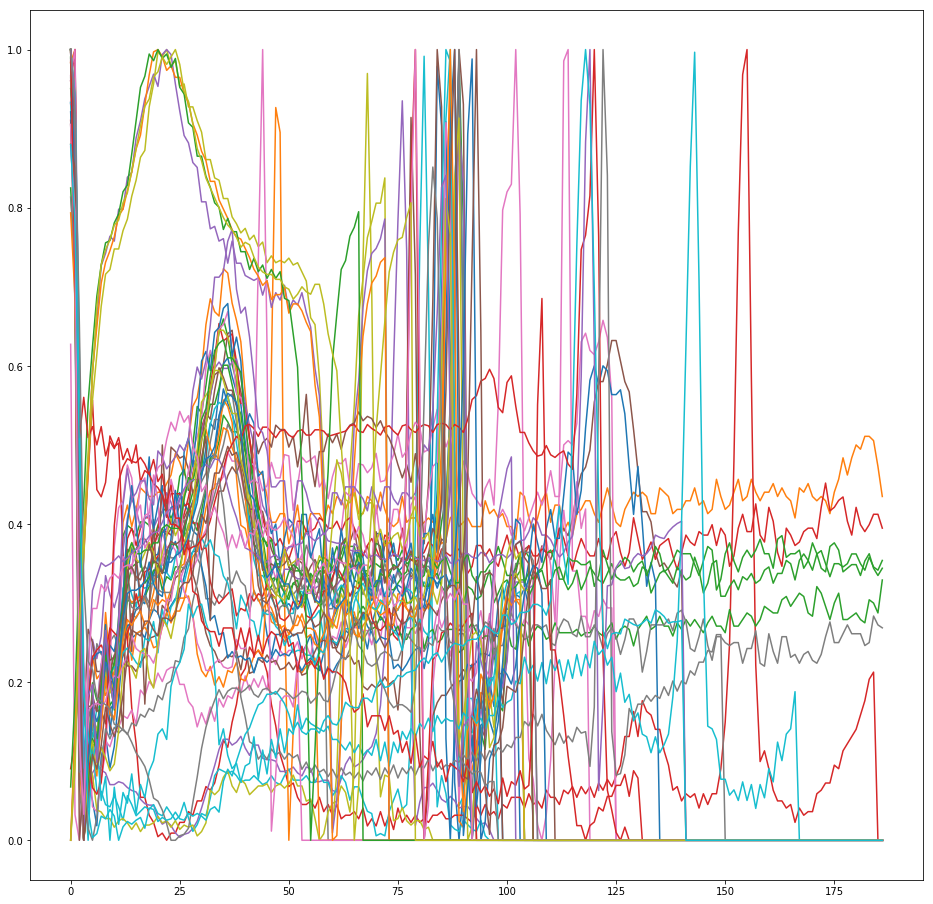

In [48]:
# Plot first 50 Supraventricular heartbeats to see if we can discern a pattern
x = np.arange(0, 187)
plt.figure(figsize=(16, 16))
for a in range(0, 50):
    plt.plot(x,train_df[supraventricular].values[:,:-1][a], label="Supraventricular "+str(a))
#plt.legend()

In [49]:
# Helper function to get the name of the array
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]
namestr(normal,globals())

'normal'

MovieWriter ffmpeg unavailable.


ValueError: unknown file extension: .mp4

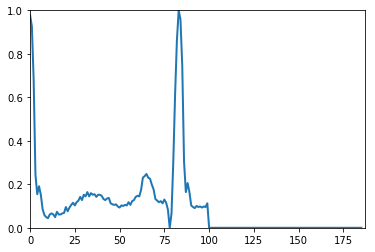

In [29]:
# Animtaions of heartbeats 
# Based on http://jakevdp.github.com from Jake Vanderplas
def animateECG(dataset):

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure()
    ax = plt.axes(xlim=(0, 187), ylim=(0, 1))
    line, = ax.plot([], [], lw=2)
    
    def namestr(obj, namespace):
        return [name for name in namespace if namespace[name] is obj][0]

    # initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return line,

    # animation function.  This is called sequentially
    def animate(i):
        x = range(0, 187)
        y = train_df[dataset].values[i,:-1]
        line.set_data(x,y)
        return line,

    # animation function.  This is called sequentially
    def animatePulse(i):
        x = range(0, i)
        y = train_df[dataset].values[0,0:i]
        line.set_data(x,y)
        return line,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animatePulse, init_func=init,
                                   frames=187, interval=20, blit=True,repeat=True)

    # save the animation as an mp4.  This requires ffmpeg or mencoder to be
    # installed.  The extra_args ensure that the x264 codec is used, so that
    # the video can be embedded in html5.  You may need to adjust this for
    # your system: for more information, see
    # http://matplotlib.sourceforge.net/api/animation_api.html
    fileName = namestr(dataset,globals()) + "_heart.mp4"
    anim.save(fileName, fps=30, extra_args=['-vcodec', 'libx264'])
    
animateECG(normal)
animateECG(supraventricular)
animateECG(ventricular) 
animateECG(fusion) 
animateECG(unclassified) 

#ToDo - make GIF repeat
    

<img src="normal_heart.gif">
<img src="supraventricular_heart.gif">
<img src="ventricular_heart.gif"> 
<img src="fusion_heart.gif">
<img src="unclassified_heart.gif">

In [ ]:
# Use a 3D plot to explore
def PlotPulses3D(numberOfLines=5, dataset=normal):

    fig = plt.figure(figsize=(16, 16))
    ax = fig.gca(projection='3d')


    def cc(arg):
        return mcolors.to_rgba(arg, alpha=0.6)

    train_df[supraventricular].values[:,:-1][0]

    xs = np.arange(0, 10, 0.4)
    verts = []
    zs = list(range(0,numberOfLines))
    for z in range(numberOfLines):
        #ys = np.random.rand(len(xs))
        #ys[0], ys[-1] = 0, 0
        verts.append(list(zip( range(len(train_df[dataset].values[:,:-1][z])),train_df[dataset].values[:,:-1][z])))

    lines = LineCollection(verts)

    lines.set_alpha(0.7)
    ax.add_collection3d(lines , zs=zs, zdir='y')

    ax.set_xlabel('X')
    ax.set_xlim3d(0, 200)
    ax.set_ylabel('Y')
    ax.set_ylim3d(-1, numberOfLines)
    ax.set_zlabel('Z')
    ax.set_zlim3d(0, 1)
    ax.view_init(azim=270)

    plt.show()
    
PlotPulses3D(numberOfLines=30,dataset=normal)
PlotPulses3D(numberOfLines=30,dataset=ventricular)
PlotPulses3D(numberOfLines=30,dataset=supraventricular)
PlotPulses3D(numberOfLines=30,dataset=fusion)
PlotPulses3D(numberOfLines=30,dataset=unclassified)
# Try to 

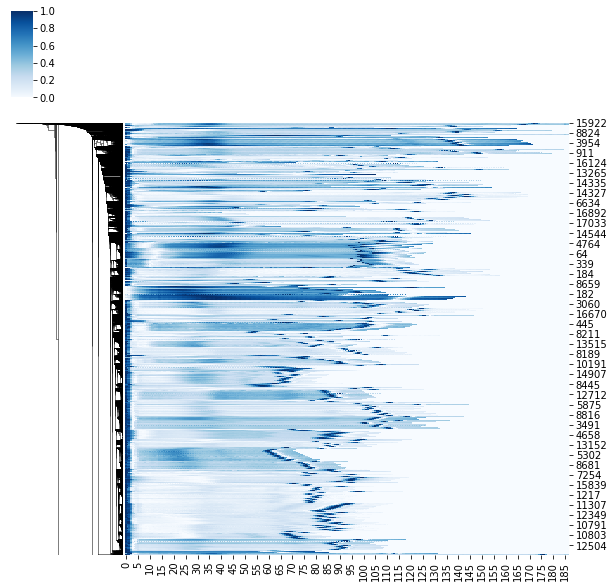

In [32]:
# Try to use a heatmap with clustering to find patterns

# Prepare a vector of color mapped to the 'cyl' column
#my_palette = dict(zip(y_train, ["orange","yellow","brown","red","blue"]))
#row_colors = y_train.map(my_palette)
 
# plot
sns.clustermap(X_train, metric="correlation", method="single", cmap="Blues", col_cluster= False, standard_scale=1)
# ToDo use kNN to try to cluster pulses, perhaps average them into buckets ask Justin

## Machin Learning Models

### SVM

In [33]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 
# model accuracy for X_test   
accuracy = svm_model_linear.score(X_test, y_test) 
print(accuracy)

0.9218821379625399


### Confusion Matrix

In [34]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test, svm_predictions)
print(cm)

[[1812    3   14    0    0]
 [  24   28    3    0    0]
 [  94    1   47    2    0]
 [   9    0    1    4    0]
 [  20    0    0    0  127]]


Normalized confusion matrix
[[0.99 0.   0.01 0.   0.  ]
 [0.44 0.51 0.05 0.   0.  ]
 [0.65 0.01 0.33 0.01 0.  ]
 [0.64 0.   0.07 0.29 0.  ]
 [0.14 0.   0.   0.   0.86]]


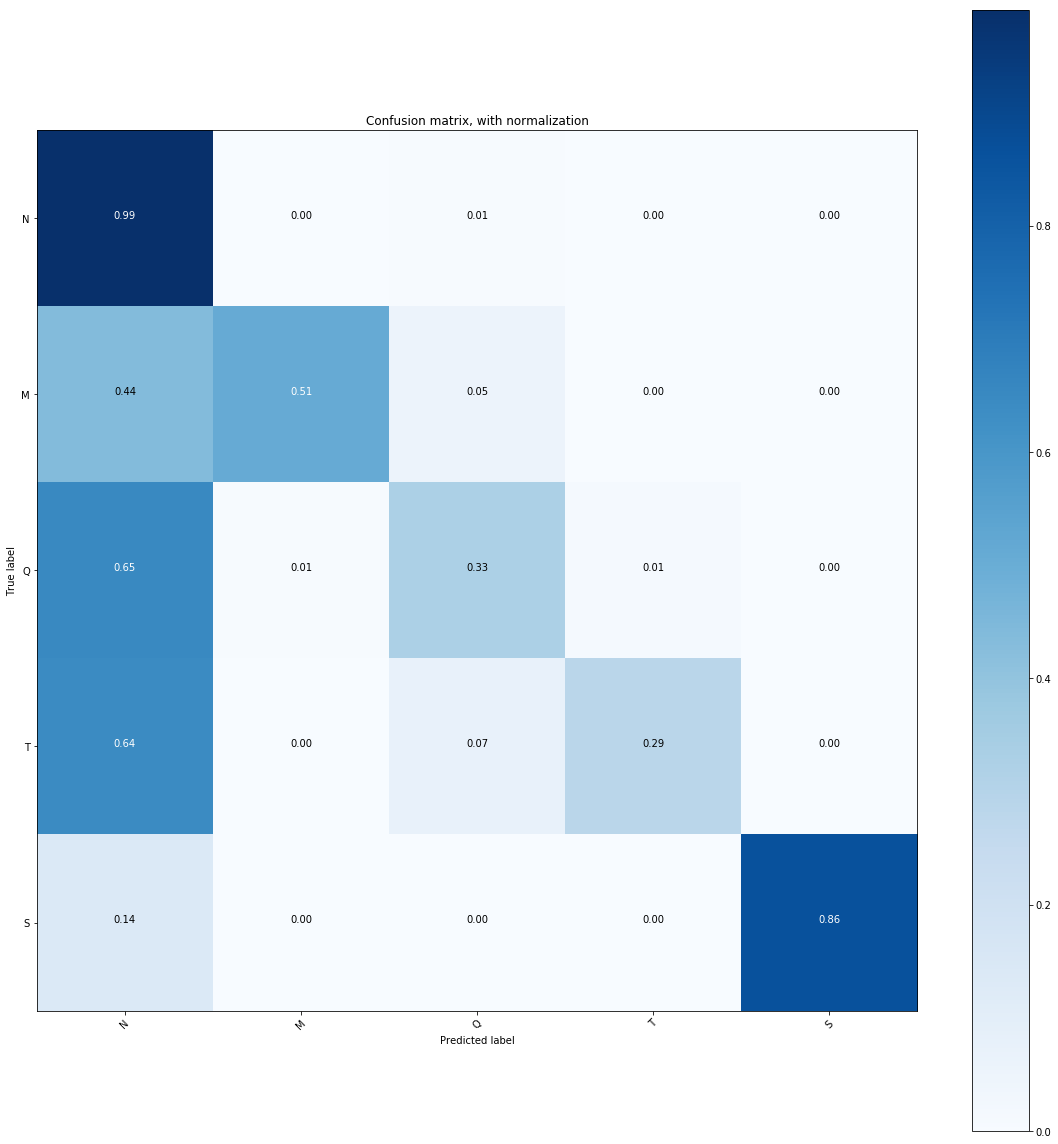

In [35]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

class_names = ['N','M','Q','T','S']


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
np.set_printoptions(precision=2)

plt.figure(figsize=(16, 16))
plot_confusion_matrix(cm, normalize=True, classes=class_names,
                      title='Confusion matrix, with normalization')
plt.show()

### Grid Search

In [43]:
# Based on http://scikwarnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.1, 1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'gamma': [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
                      'C': [0.1, 1, 10, 100, 1000]}]
scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, n_jobs = -1, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

Grid scores on development set:

0.776 (+/-0.008) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.565 (+/-0.010) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.368 (+/-0.003) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.166 (+/-0.000) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.166 (+/-0.000) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.166 (+/-0.000) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.964 (+/-0.047) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.974 (+/-0.016) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.552 (+/-0.011) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.366 (+/-0.005) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.166 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.166 (+/-0.000) for {'C': 1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.952 (+/-0.034) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.943 (+/-0.050) for {

             precision    recall  f1-score   support

          0       0.98      0.98      0.98      1829
          1       0.69      0.69      0.69        55
          2       0.96      0.91      0.93       144
          3       0.53      0.57      0.55        14
          4       0.98      0.96      0.97       147

avg / total       0.97      0.97      0.97      2189




In [71]:
# Only take a random number of samples for training and test data sets.
sampleFraction = 1.0
X_train = train_df.sample(random_state=1,frac=sampleFraction, replace=True).values[:, :-1]
y_train = train_df.sample(random_state=1,frac=sampleFraction, replace=True).values[:, -1].astype(int)
X_test = test_df.sample(random_state=1,frac=sampleFraction, replace=True).values[:, :-1]
y_test = test_df.sample(random_state=1,frac=sampleFraction, replace=True).values[:, -1].astype(int)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)
# ToDo balance the data sets away from normal bias

X_train (87554, 187)
y_train (87554,)
X_test (21892, 187)
y_test (21892,)


Normalized confusion matrix
[[9.98e-01 7.18e-04 8.28e-04 0.00e+00 1.10e-04]
 [4.19e-01 5.79e-01 1.83e-03 0.00e+00 0.00e+00]
 [1.07e-01 6.89e-04 8.76e-01 1.52e-02 1.38e-03]
 [4.94e-01 0.00e+00 7.65e-02 4.29e-01 0.00e+00]
 [1.02e-01 0.00e+00 4.33e-03 0.00e+00 8.93e-01]]


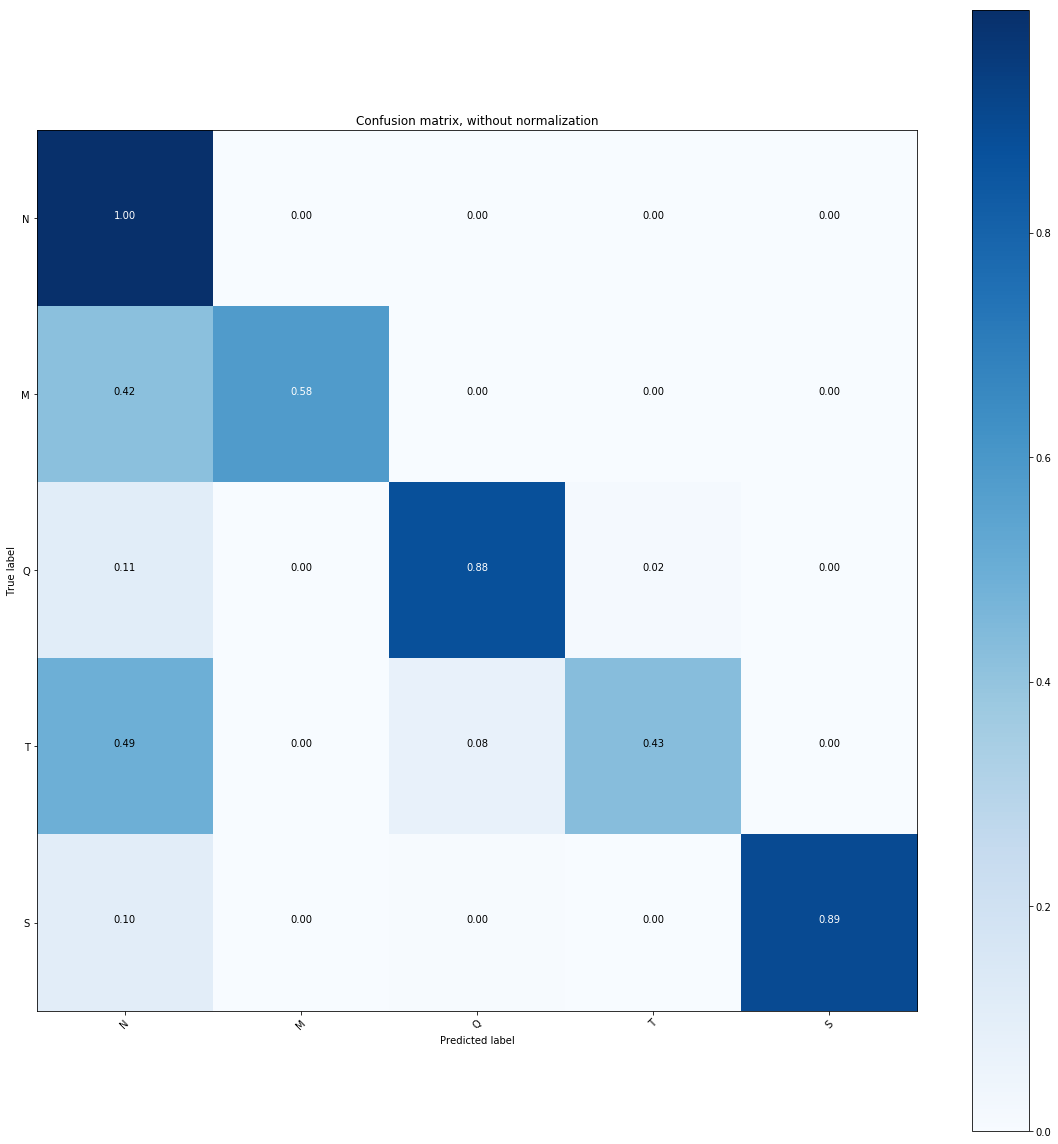

0.9676137401790609


In [60]:
svm_model_linear = SVC(kernel = 'rbf', C = 1, gamma =0.1 ).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 
  
# model accuracy for X_test   
accuracy = svm_model_linear.score(X_test, y_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, svm_predictions) 

# Plot non-normalized confusion matrix

plt.figure(figsize=(16, 16))
plot_confusion_matrix(cm, normalize=True, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()
print(accuracy)

In [72]:
import time
import numpy as np
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

X = X_train
y = y_train
start = time.time()
# See https://www.youtube.com/watch?v=ZvaELFv5IpM 
clf = OneVsRestClassifier(SVC(kernel='rbf', probability=True), n_jobs=-1)
clf.fit(X, y)
end = time.time()
print("Single SVC", end - start, clf.score(X,y))
proba = clf.predict_proba(X)
# model accuracy for X_test   
accuracy = clf.score(X_test, y_test) 
print(accuracy)
# creating a confusion matrix 
#cm = confusion_matrix(y, proba) 
# Plot non-normalized confusion matrix
#plt.figure(figsize=(16, 16))
#plot_confusion_matrix(cm, normalize=True, classes=class_names,
#                      title='Confusion matrix OneVsRestClassifier SVM')
#plt.show()

n_estimators = 10
start = time.time()
# See https://www.youtube.com/watch?v=2Mg8QD0F1dQ 
clf = OneVsRestClassifier(BaggingClassifier(SVC(kernel='rbf', probability=True), max_samples=1.0 / n_estimators, n_estimators=n_estimators), n_jobs=-1)
clf.fit(X, y)
end = time.time()
print("Bagging SVC", end - start, clf.score(X,y))
proba = clf.predict_proba(X)
# model accuracy for X_test   
accuracy = clf.score(X_test, y_test) 
print(accuracy)
# creating a confusion matrix 
#cm = confusion_matrix(y_test, proba) 
# Plot non-normalized confusion matrix
#plt.figure(figsize=(16, 16))
#plot_confusion_matrix(cm, normalize=True, classes=class_names,
#                      title='Confusion matrix OneVsRestClassifier BaggingClassifier')
#plt.show()

start = time.time()
clf = RandomForestClassifier(min_samples_leaf=20)
clf.fit(X, y)
end = time.time()
print("Random Forest", end - start, clf.score(X,y))
proba = clf.predict_proba(X)
# model accuracy for X_test   
accuracy = clf.score(X_test, y_test) 
print(accuracy)
# creating a confusion matrix 
#cm = confusion_matrix(y_test, proba) 
# Plot non-normalized confusion matrix
#plt.figure(figsize=(16, 16))
#plot_confusion_matrix(cm, normalize=True, classes=class_names,
#                      title='Confusion matrix RandomForestClassifier')
#plt.show()

Single SVC 4737.580696582794 0.9256687301551043
0.9240361775991229
Bagging SVC 433.87979197502136 0.889690933595267
0.8879042572629271
Random Forest 11.32392430305481 0.9725883454782192
0.9625890736342043


Normalized confusion matrix
[[0.99 0.   0.01 0.  ]
 [1.   0.   0.   0.  ]
 [0.62 0.   0.31 0.06]
 [0.07 0.   0.   0.93]]


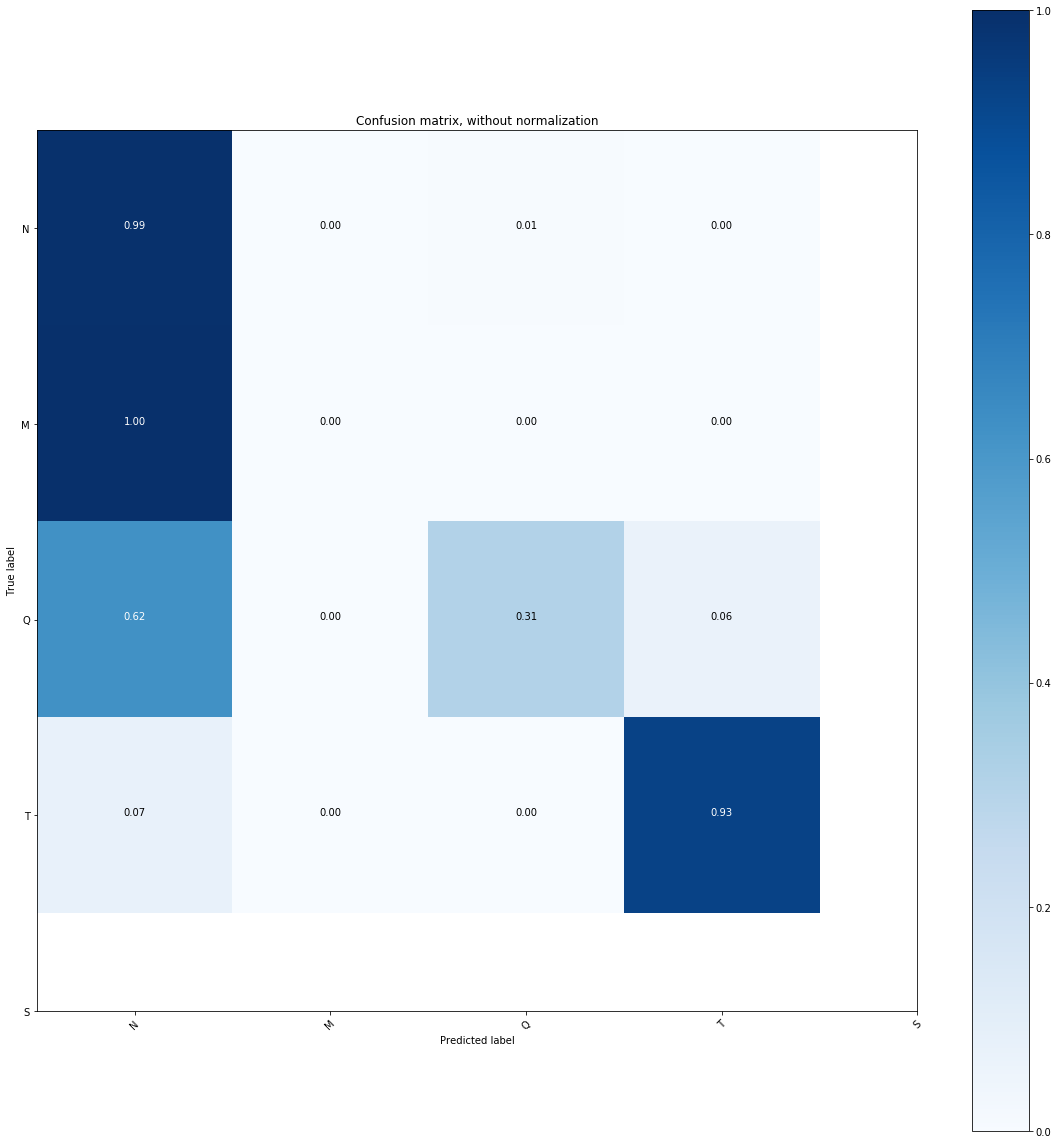

0.9223744292237442


In [94]:
# training a KNN classifier 
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 5).fit(X_train, y_train) 
  
# accuracy on X_test 
accuracy = knn.score(X_test, y_test) 
  
# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  
cm = confusion_matrix(y_test, knn_predictions) 

# Plot non-normalized confusion matrix
plt.figure(figsize=(16, 16))
plot_confusion_matrix(cm, normalize=True, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()
print(accuracy)